In [3]:
import numpy as np

def create_square_wave(frequency, amplitude, duration, sampling_rate):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    wave = amplitude * np.sign(np.sin(2 * np.pi * frequency * t)).astype(float)
    return t, wave

# Example usage:
frequency = 261.6  # Hz
amplitude = 1.0  # Unit
duration = 5.0   # Second
sampling_rate = 44100  # Hz

t, wave = create_square_wave(frequency, amplitude, duration, sampling_rate)

In [22]:
def create_mixed_wave(frequencies, amplitude, duration, sampling_rate):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    wave = np.zeros_like(t)
    for freq in frequencies:
        wave += amplitude * np.sin(2 * np.pi * freq * t)
    return t, wave

# Example usage:
middle_c = 261.6  # Hz
semitone = 2 ** (1 / 12)
frequencies = [(middle_c * semitone ** i) for i in range(10)]
amplitude = 0.1  # Unit
duration = 5  # Seconds
sampling_rate = 44100  # Hz

t, wave = create_mixed_wave(frequencies, amplitude, duration, sampling_rate)

In [18]:
def create_static_noise(amplitude, duration, sampling_rate):
    num_samples = int(duration * sampling_rate)
    noise = amplitude * np.random.uniform(-1, 1, num_samples)
    t = np.linspace(0, duration, num_samples, endpoint=False)
    return t, noise

# Example usage:
duration = 5.0  # Seconds
sampling_rate = 44100  # Hz
noise_amplitude = 1.0  # Unit
t, wave = create_static_noise(noise_amplitude, duration, sampling_rate)

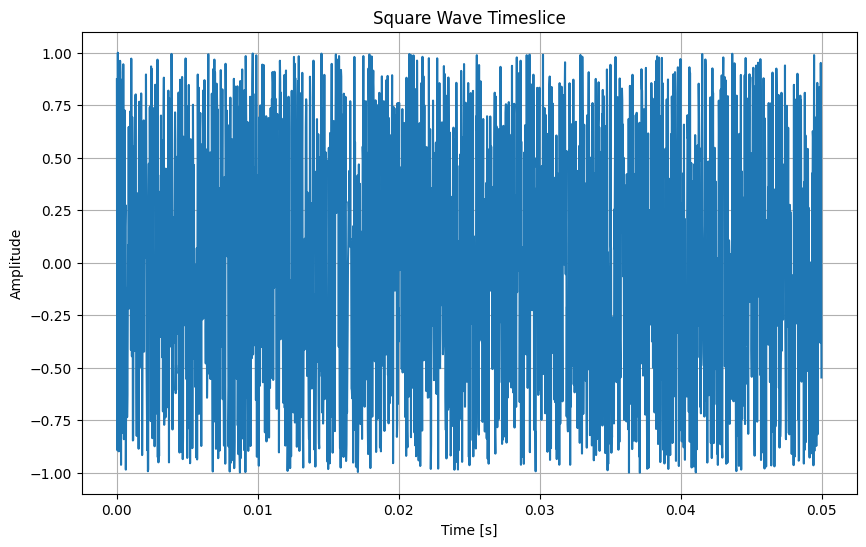

In [228]:
# Define the timeslice range (e.g., from 0 to 0.01 seconds)
start_time = 0
end_time = 0.05

# Find the indices corresponding to the start and end times
start_index = int(start_time * sampling_rate)
end_index = int(end_time * sampling_rate)

# Slice the time and wave arrays
t_slice = t[start_index:end_index]
wave_slice = wave[start_index:end_index]

# Plot the timeslice
plt.figure(figsize=(10, 6))
plt.plot(t_slice, wave_slice)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Square Wave Timeslice')
plt.grid(True)
plt.show()

In [ ]:
from scipy.signal import butter, filtfilt

def band_pass_filter(data, lowcut, highcut, sampling_rate, filter_type='band', order=4):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    
    if filter_type == 'band':
        b, a = butter(order, [low, high], btype='band')
    elif filter_type == 'low':
        b, a = butter(order, low, btype='low')
    elif filter_type == 'high':
        b, a = butter(order, high, btype='high')
    else:
        raise ValueError("filter_type must be 'band', 'low', or 'high'")
    
    y = filtfilt(b, a, data)
    return y

# Example usage:
lowcut = 200.0  # Hz
highcut = 300.0  # Hz

filtered_stream = band_pass_filter(wave, lowcut, highcut, sampling_rate, filter_type='band', order=4)

In [27]:
from scipy.signal import butter, lfilter

# Define the Butterworth filter
order = 4
lowcut = 300.0  # Hz
highcut = 500.0  # Hz
nyquist = 0.5 * sampling_rate
frame_size = 512
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(order, [low, high], btype='band')

# Process the stream in batches
filtered_stream = np.zeros_like(streamed_data)
num_frames = len(streamed_data) // frame_size

# Initialize the filter state
zi = np.zeros((max(len(a), len(b)) - 1,))

for i in range(num_frames):
    start = i * frame_size
    end = start + frame_size
    filtered_stream[start:end], zi = lfilter(b, a, streamed_data[start:end], zi=zi)

# If there are remaining samples that don't fit into a full frame, process them as well
if len(streamed_data) % frame_size != 0:
    start = num_frames * frame_size
    filtered_stream[start:], _ = lfilter(b, a, streamed_data[start:], zi=zi)

# filtered_stream now contains the filtered audio data

In [233]:
import sounddevice as sd

# Play the sound
sd.play(filtered_stream, samplerate=sampling_rate)
sd.wait()  # Wait until the sound has finished playing

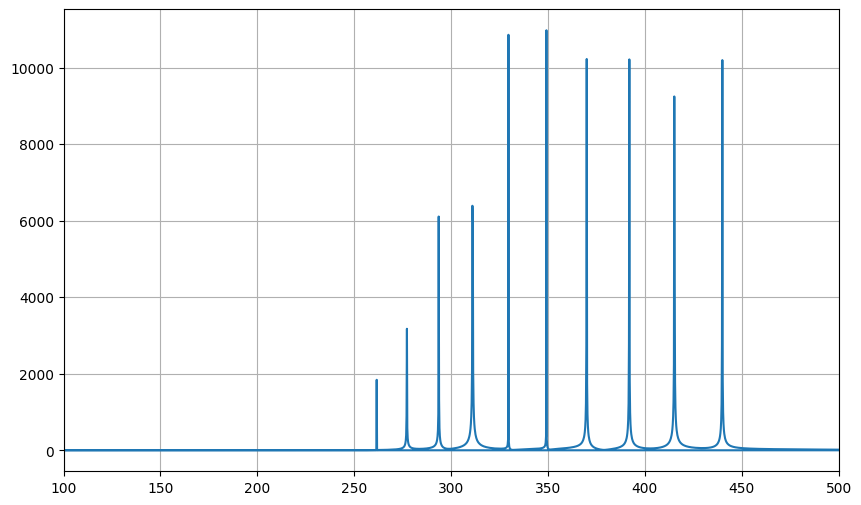

In [28]:
import matplotlib.pyplot as plt

# Compute the Fast Fourier Transform (FFT)
fft_wave = np.fft.fft(filtered_stream)
fft_freq = np.fft.fftfreq(len(filtered_stream), 1/sampling_rate)

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
plt.plot(fft_freq, np.abs(fft_wave))
plt.xlim(100, 500)  # Limit x-axis to twice the fundamental frequency for better visualization
plt.grid(True)
plt.show()

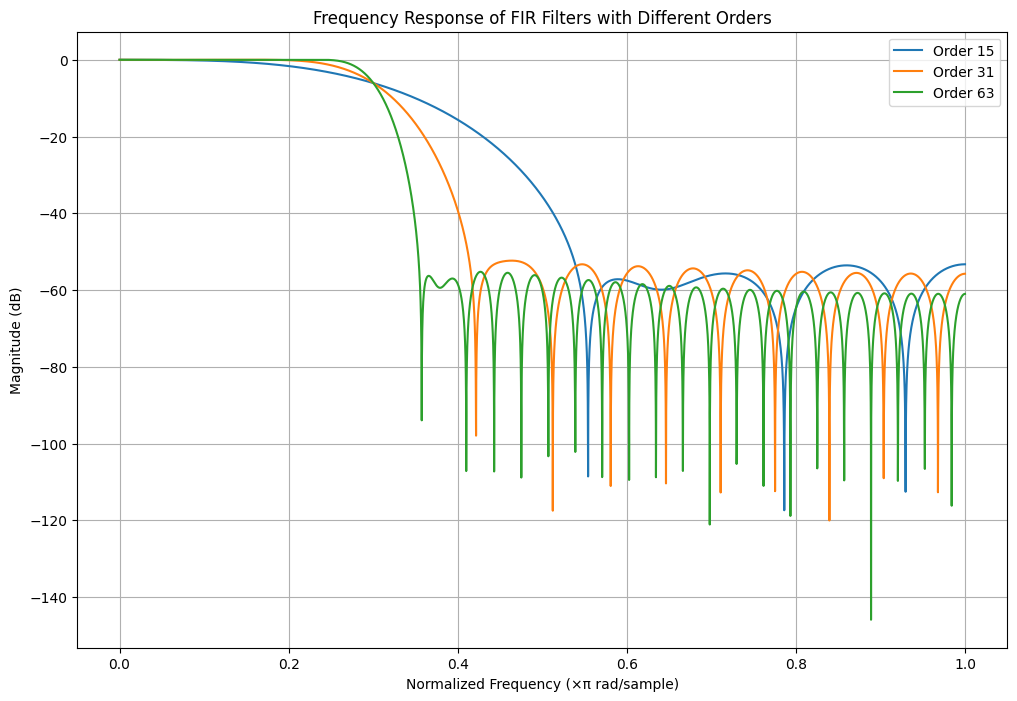

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz

# Design FIR filters of different orders
orders = [15, 31, 63]
cutoff = 0.3  # Normalized cutoff frequency (0.3 * Nyquist frequency)
filters = [firwin(order, cutoff) for order in orders]

# Plot frequency responses
plt.figure(figsize=(12, 8))
for order, filt in zip(orders, filters):
    w, h = freqz(filt, worN=8000)
    plt.plot(w / np.pi, 20 * np.log10(np.abs(h)), label=f'Order {order}')

plt.title('Frequency Response of FIR Filters with Different Orders')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid()
plt.show()

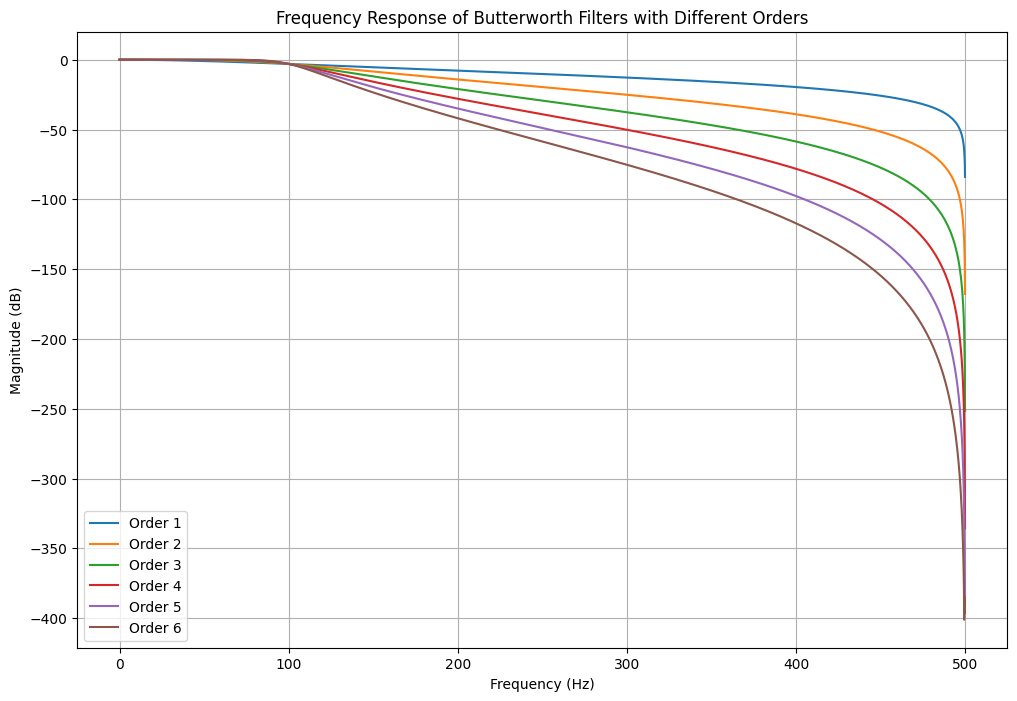

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz

# Define the sampling rate and cutoff frequency
sampling_rate = 1000  # Hz
cutoff = 100  # Hz

# Design Butterworth filters of different orders
orders = [1, 2, 3, 4, 5, 6]
filters = [butter(order, cutoff / (0.5 * sampling_rate), btype='low', analog=False) for order in orders]

# Plot frequency responses
plt.figure(figsize=(12, 8))
for order, (b, a) in zip(orders, filters):
    w, h = freqz(b, a, worN=8000)
    plt.plot(0.5 * sampling_rate * w / np.pi, 20 * np.log10(np.abs(h)), label=f'Order {order}')

plt.title('Frequency Response of Butterworth Filters with Different Orders')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid()
plt.show()